In [17]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the data from CSV file
df = pd.read_csv("Office_Garman.csv")
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

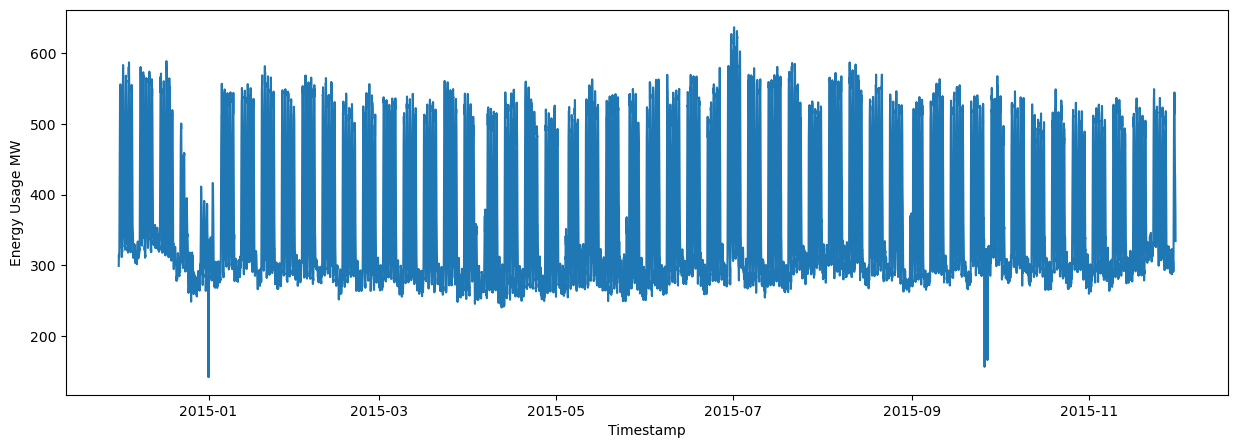

In [3]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(df)
plt.xlabel('Timestamp')
plt.ylabel('Energy Usage MW')
plt.show()

In [25]:
# Read weather data
weather_data = pd.read_csv("weather5.csv")
weather_data = weather_data.set_index('timestamp')
weather_data.index = pd.to_datetime(weather_data.index)

# Merge weather data into the main dataframe
df = df.merge(weather_data, how='left', left_index=True, right_index=True)

# Read holiday schedule
holiday_schedule = pd.read_csv("schedule9.csv", header=None)
holiday_schedule.columns = ['date', 'holiday_flag']
holiday_schedule['date'] = pd.to_datetime(holiday_schedule['date'])
holiday_schedule = holiday_schedule.set_index('date')

# Merge holiday schedule into the main dataframe
df = df.merge(holiday_schedule, how='left', left_index=True, right_index=True)


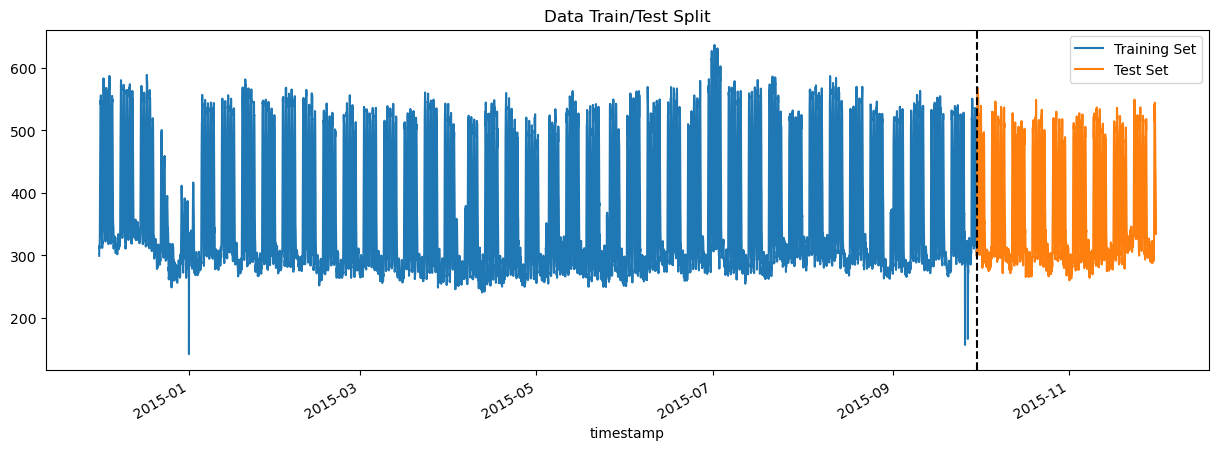

In [7]:
# Define the split date
split_date = '2015-09-30'

# Split the data into training and testing sets
train = df.loc[:split_date]
test = df.loc[split_date:]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

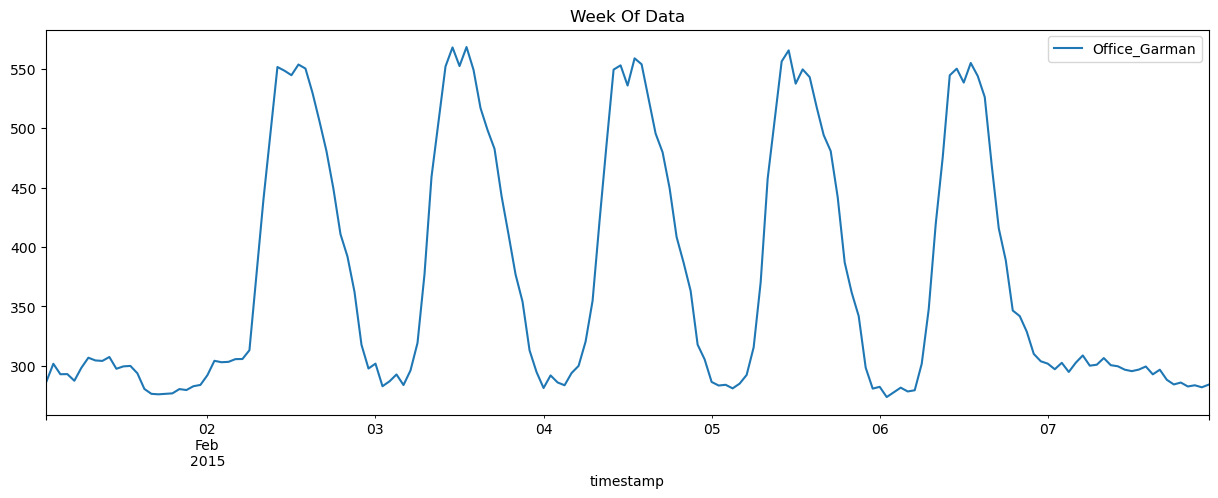

In [5]:
df.loc[(df.index > '02-01-2015') & (df.index < '02-08-2015')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

### Feature Creation

In [26]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

### Visualize our Feature / Target Relationship

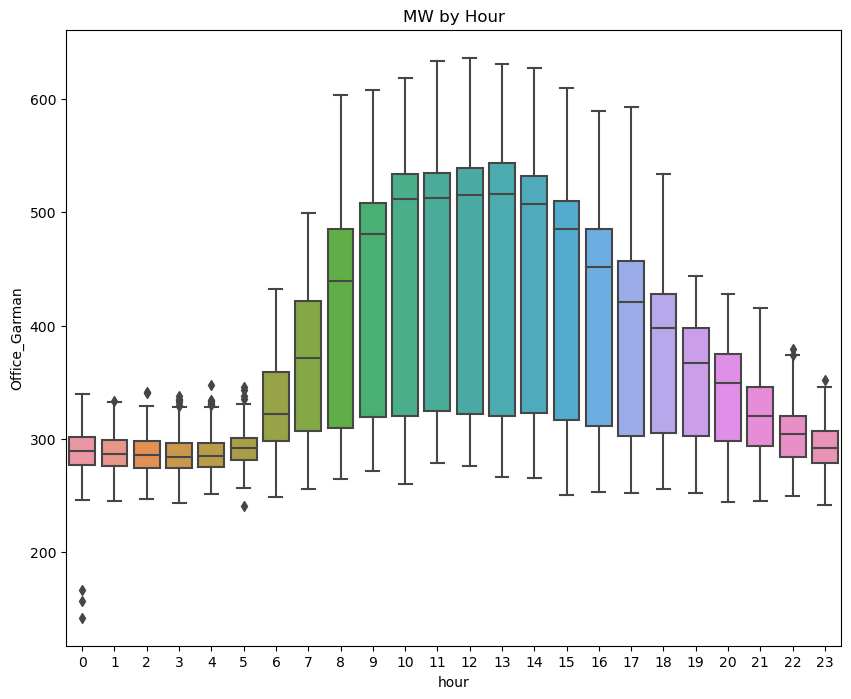

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Office_Garman')
ax.set_title('MW by Hour')
plt.show()

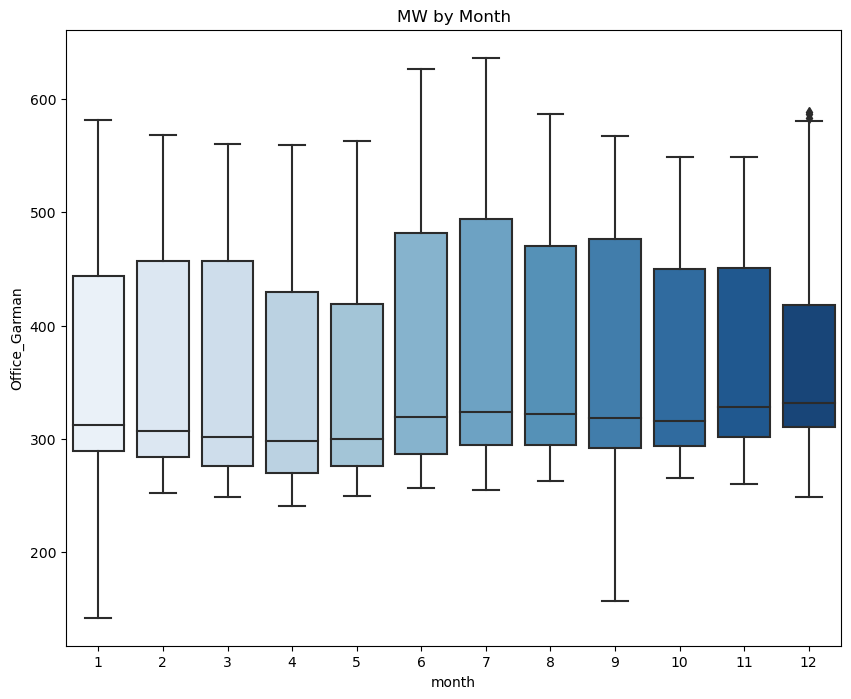

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Office_Garman', palette='Blues')
ax.set_title('MW by Month')
plt.show()

### Creating the model

In [24]:
train = create_features(train)
test = create_features(test)

# Define the features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'Conditions', 'Dew PointC', 'Events', 'Gust SpeedKm/h', 'Humidity',
            'Precipitationmm', 'Sea Level PressurehPa', 'TemperatureC',
            'TimeBST', 'TimeGMT', 'VisibilityKm', 'Wind Direction',
            'Wind SpeedKm/h', 'WindDirDegrees', 'holiday_flag']
TARGET = 'Office_Garman'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


KeyError: "['Conditions', 'Dew PointC', 'Events', 'Gust SpeedKm/h', 'Humidity', 'Precipitationmm', 'Sea Level PressurehPa', 'TemperatureC', 'TimeBST', 'TimeGMT', 'VisibilityKm', 'Wind Direction', 'Wind SpeedKm/h', 'WindDirDegrees', 'holiday_flag'] not in index"

In [25]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[12:15:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:375.50483	validation_1-rmse:373.67576
[100]	validation_0-rmse:142.15293	validation_1-rmse:137.49865
[200]	validation_0-rmse:60.64461	validation_1-rmse:51.85055
[300]	validation_0-rmse:35.32714	validation_1-rmse:24.17265
[400]	validation_0-rmse:28.10376	validation_1-rmse:21.57803
[414]	validation_0-rmse:27.63447	validation_1-rmse:21.82941


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

### Feature Importance

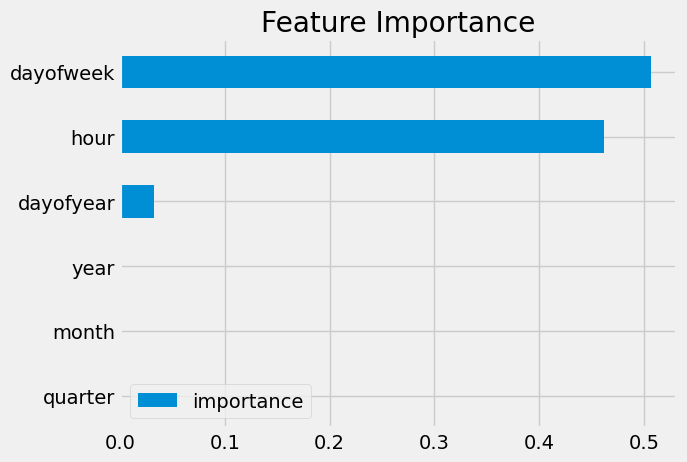

In [26]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forecast on Test

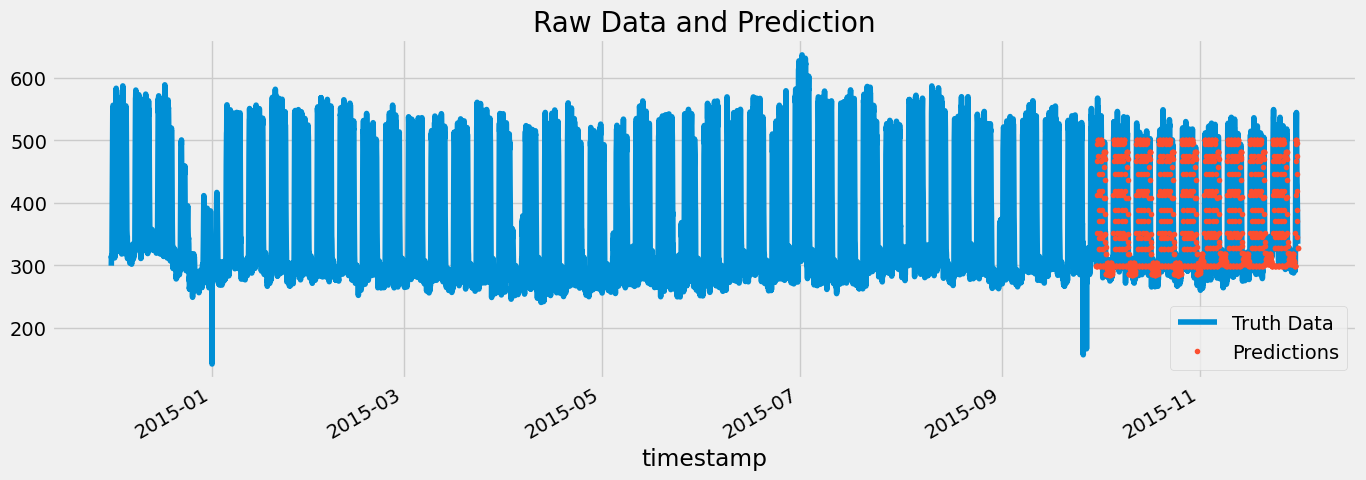

In [29]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Office_Garman']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

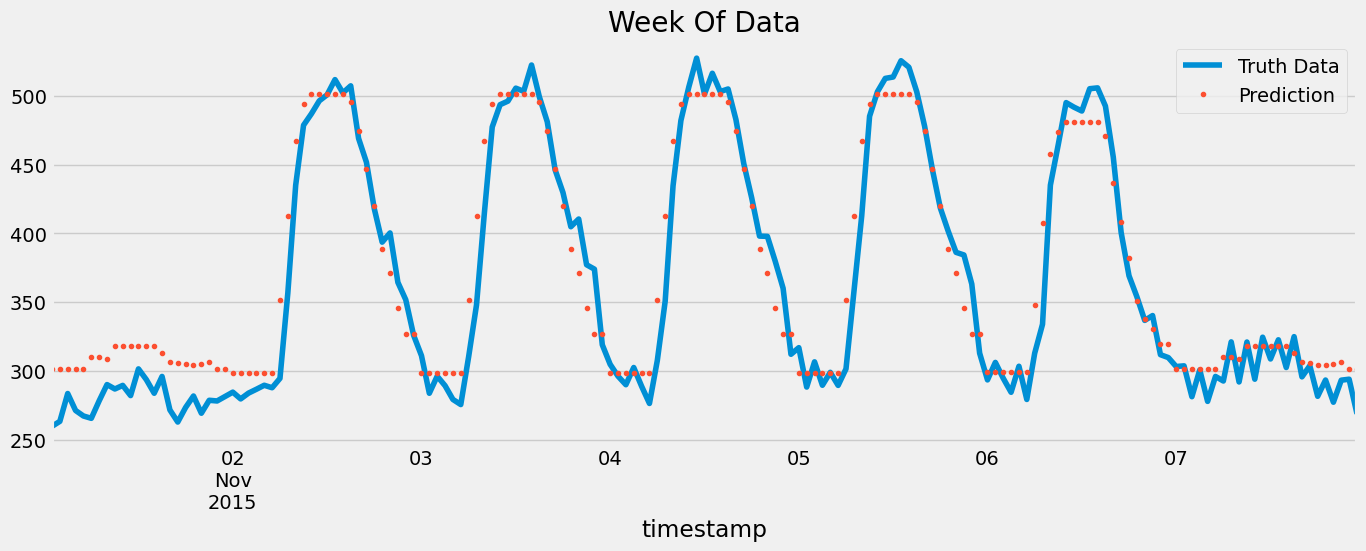

In [35]:
ax = df.loc[(df.index > '11-01-2015') & (df.index < '11-08-2015')]['Office_Garman'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '11-01-2015') & (df.index < '11-08-2015')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

### Score (RMSE)

In [37]:
score = np.sqrt(mean_squared_error(test['Office_Garman'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 21.18


### Calculate Error
Looking at the worst and best predicted days

In [38]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-11-01    29.445236
2015-11-23    28.520159
2015-11-17    24.550860
2015-11-09    23.631182
2015-11-30    23.486794
2015-11-08    23.295092
2015-11-24    21.801160
2015-10-09    21.413587
2015-11-10    20.481155
2015-10-13    20.130554
Name: error, dtype: float64

In [11]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17227 entries, 2014-12-01 00:20:00 to 2015-11-30 23:50:00
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Conditions             17227 non-null  object 
 1   DateUTC<br />          17227 non-null  object 
 2   Dew PointC             17227 non-null  float64
 3   Events                 1570 non-null   object 
 4   Gust SpeedKm/h         17227 non-null  object 
 5   Humidity               17227 non-null  int64  
 6   Precipitationmm        0 non-null      float64
 7   Sea Level PressurehPa  17227 non-null  int64  
 8   TemperatureC           17227 non-null  float64
 9   TimeBST                9924 non-null   object 
 10  TimeGMT                7303 non-null   object 
 11  VisibilityKm           17227 non-null  float64
 12  Wind Direction         17227 non-null  object 
 13  Wind SpeedKm/h         17227 non-null  object 
 14  WindDirDegrees     